In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import math

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [27]:
df_train = pd.read_hdf('../data/EC15_split.h5', key="train")
df_valid = pd.read_hdf('../data/EC15_split.h5', key="validation")
df_test = pd.read_hdf('../data/EC15_split.h5', key="test")

df_train = pd.concat([df_train, df_valid])
df_train.sort_index(inplace=True)

interesting_cols = df_train.columns[df_train.columns.str.endswith('24')]

## Feature engineering

In [30]:
def log_returns(series_prices):
    return np.log(series_prices).diff()

def trend(series):
    return (series[-1] - series[0]) / len(series)

def diff(series):
    return (series[-1] - series[0])

def diff_max(series):
    return np.max(series - series[0])

def diff_min(series):
    return np.min(series - series[0])

def diff_mean(series):
    return np.mean(series - series[0])

def geo_difference(df):
    df = df.copy()
    countries = ["FRA", "NLD", "GBR", "ESP", "DEU", "FIN", "ITA"]
    
    n_cols = []
    for s_col in df.columns:
        s_cty = s_col[s_col.find("-")+1:s_col.find("-")+4]
        for a_cty in countries:
            if a_cty != s_cty:
                a_col = s_col.replace(s_cty, a_cty)
                if a_col in df.columns:
                    n_cols.append(pd.Series(np.subtract(df[s_col],df[a_col]), name=s_col+"_minus_"+a_col))
    df = pd.concat([df] + n_cols, axis=1)
    return df

def preprocess_data(df, cols):
    df = df[cols].copy()
    
    last_days = [4]
    for period in tqdm(last_days):
        for col in cols:
            for fn in []:
                new_col_name = col + "_" + fn.__name__ + '_' + str(period)
                new_col = df[col].rolling(period).apply(fn, engine='numba', raw=True)
                df[new_col_name] = new_col
    
    return df

## Training & evaluation pipeline

In [31]:
def add_y(data, target_name, td):
    data['y'] = data[target_name].shift(-td)
    return data.drop('y', axis=1), data['y']

In [32]:
def data_split(data, target_name, td):
    from sklearn.model_selection import train_test_split
    data.sort_index(inplace=True)
    data['y'] = data[target_name].shift(-td)
    X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data['y'], test_size=0.05, shuffle=False, random_state=1)
    
    return np.array(data.index[:len(X_train)]), X_train, y_train, X_test, y_test

In [33]:
def train_lightgbm(X_train, y_train):
    import lightgbm as lgb
    
    model = lgb.LGBMRegressor(n_jobs=-1, force_col_wise=True, verbosity=0)
    model.fit(X_train, y_train)
    
    return model

In [34]:
def evaluate_lightgbm(X_train, y_train, X_valid, y_valid, td, plot=False, plt_title=''):
    model = train_lightgbm(X_train, y_train)
    
    y_hat = model.predict(X_valid)
    y = y_valid
    
    mae = np.abs(np.array(y)-np.array(y_hat))
    mae = mae[~np.isnan(mae)].mean()
    mse = np.square(np.array(y)-np.array(y_hat))
    mse = mse[~np.isnan(mse)].mean()
    
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(3, 1, figsize=(18, 12))
        sns.lineplot(x=X_valid.index[-len(y):], y=y, label='Value', ax=ax[0])
        sns.lineplot(x=X_valid.index[-len(y):], y=y_hat, label='Predicted value', ax=ax[0])
        ax[0].set_title(plt_title)
        
        sns.scatterplot(x=y, y=y_hat-y, ax=ax[1])
        
        lgb.plot_importance(model, max_num_features=10, ax=ax[2])
    
    return mae, mse, model

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 34663.67it/s]


Series mean: 0.33989487779429467
Series std: 0.13521167575899584
MAE: 0.04290841787310328
MSE: 0.0030912137158819967


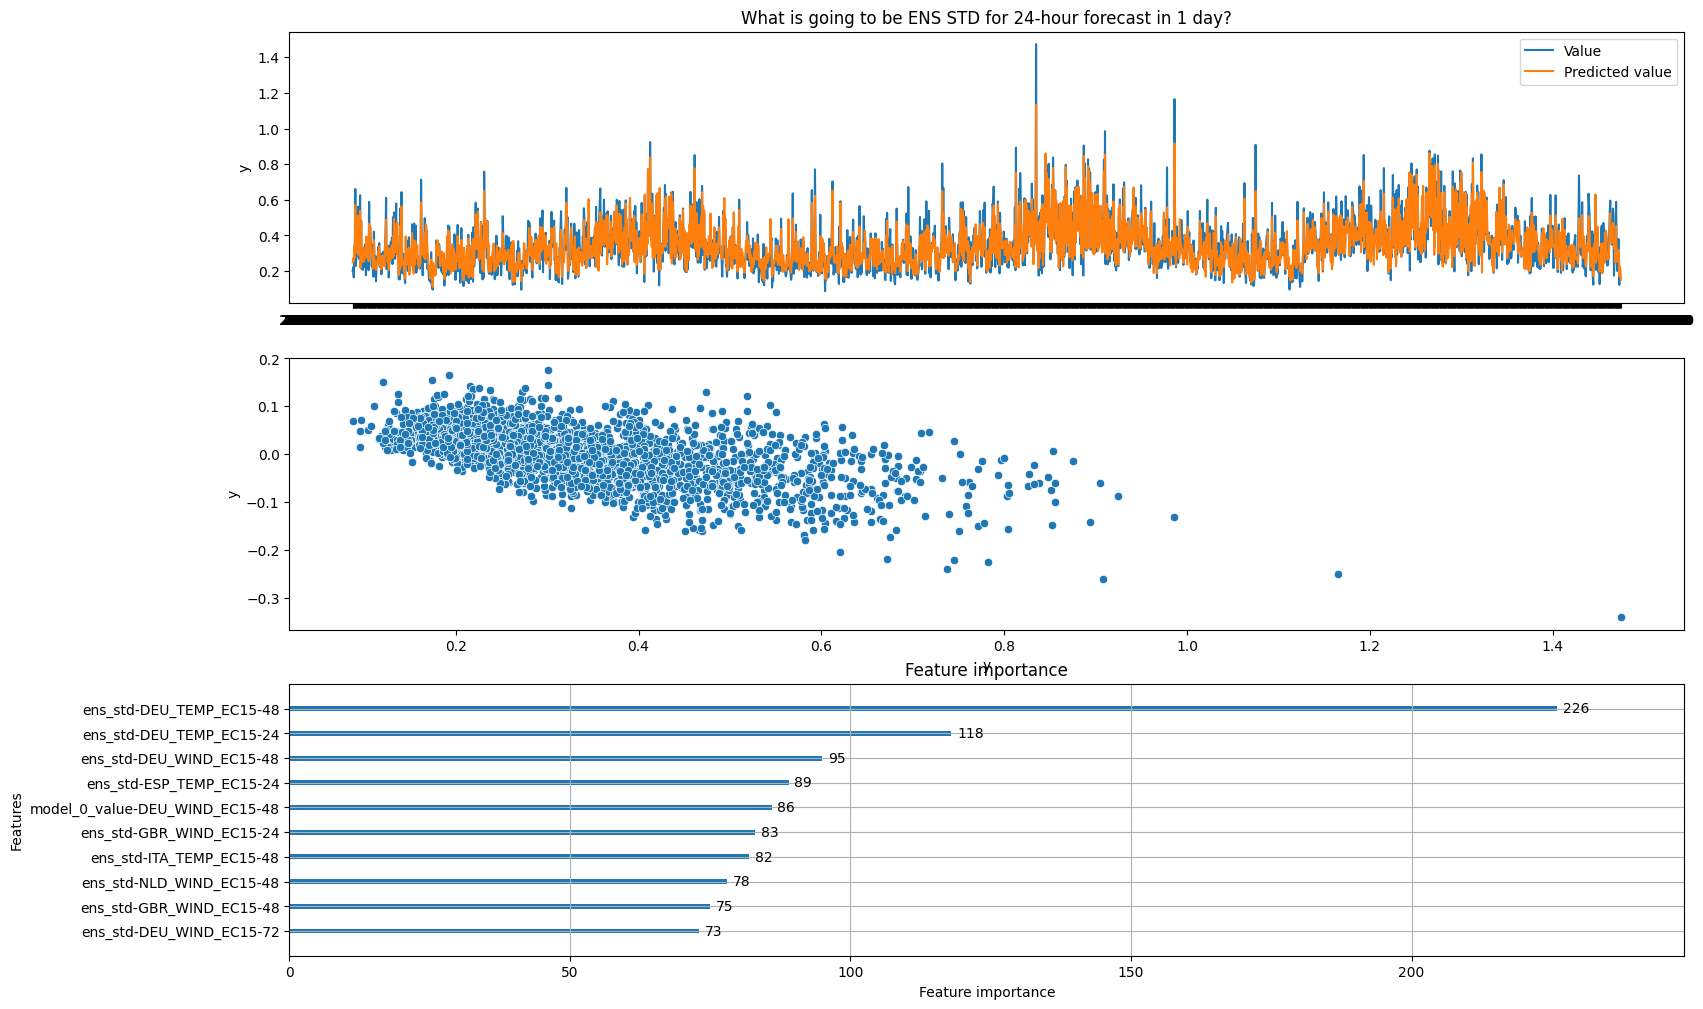

In [11]:
td = 2
forecast_horizon = 24
target_name = 'ens_std-DEU_TEMP_EC15-' + str(forecast_horizon)

for target_name in interesting_cols:
    df_train_processed = preprocess_data(geo_difference(df_train), df_train.columns)
    X_train, y_train = add_y(df_train_processed, target_name, td)

    df_valid_processed = preprocess_data(geo_difference(df_valid), df_train.columns)
    X_valid, y_valid = add_y(df_valid_processed, target_name, td)

    mae, mse, model = evaluate_lightgbm(X_train, y_train, X_valid, y_valid, td, True, 'What is going to be ENS STD for ' + str(forecast_horizon) + '-hour forecast in 1 day?')
    
    
    
    
print(f"Series mean: {y_train.mean()}")
print(f"Series std: {y_train.std()}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 35848.75it/s]


Series mean: 11.602075696375719
Series std: 7.658439851774489
MAE: 0.28467355771143465
MSE: 0.13728087686539245


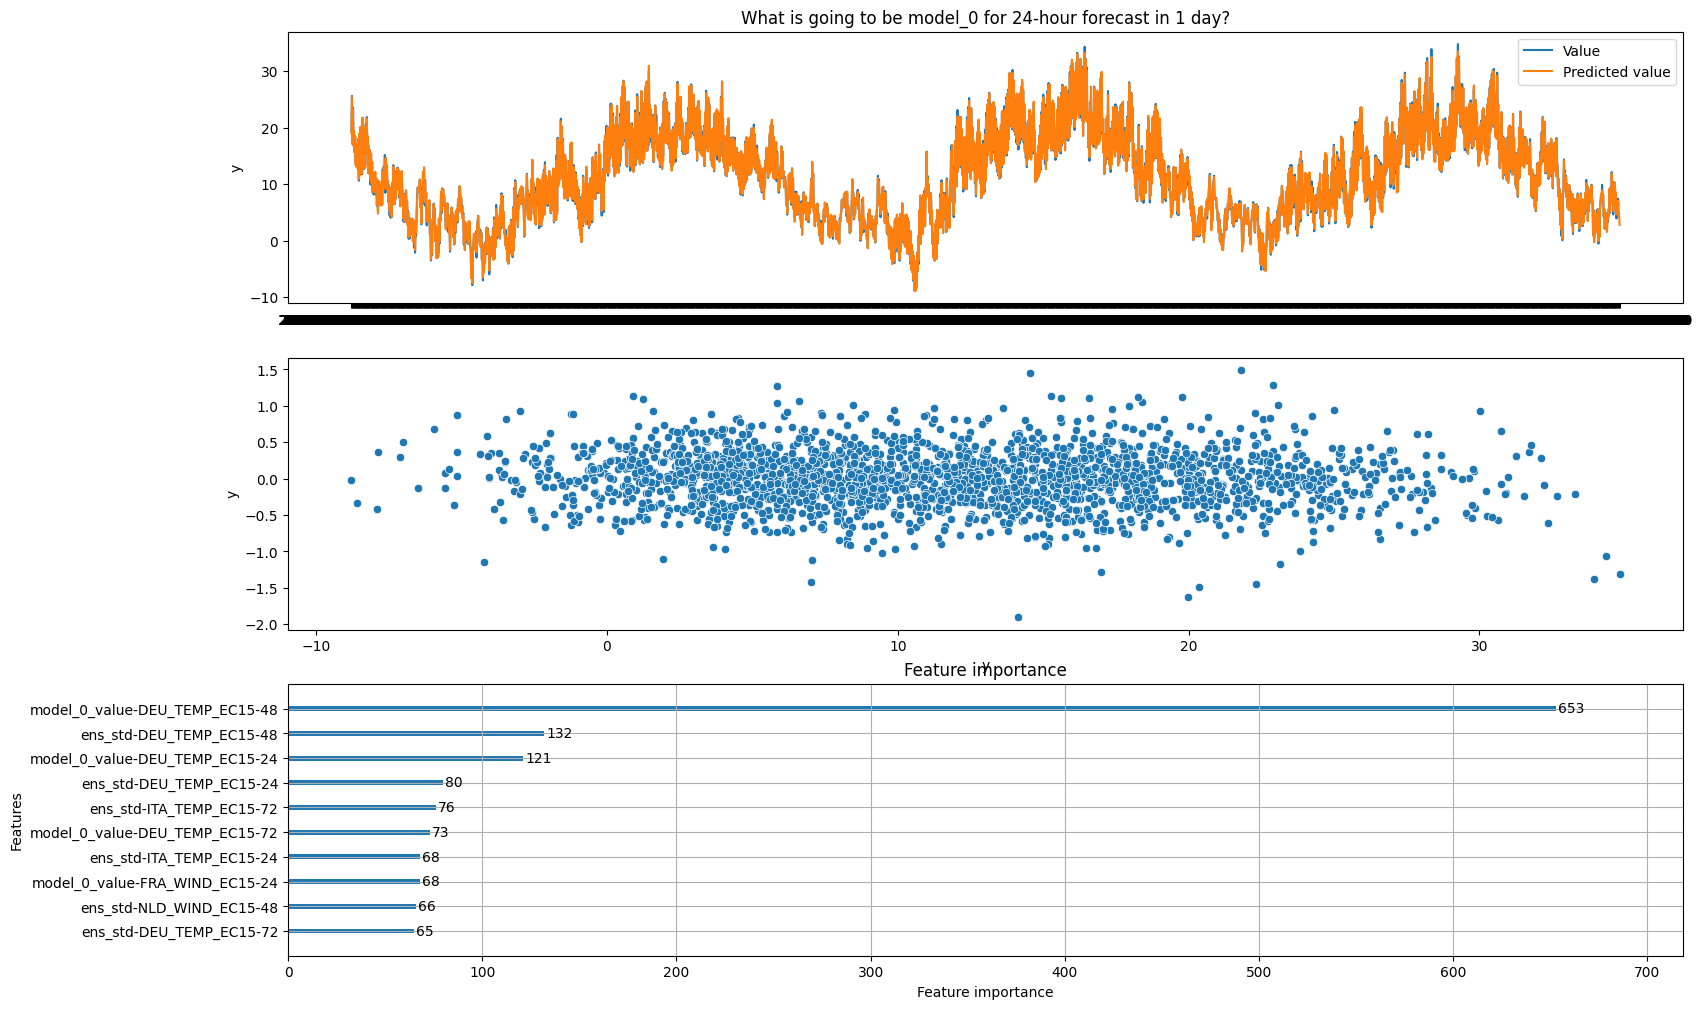

In [12]:
td = 2
forecast_horizon = 24
target_name = 'model_0_value-DEU_TEMP_EC15-' + str(forecast_horizon)

df_train_processed = preprocess_data(geo_difference(df_train), df_train.columns)
X_train, y_train = add_y(df_train_processed, target_name, td)

df_valid_processed = preprocess_data(geo_difference(df_valid), df_train.columns)
X_valid, y_valid = add_y(df_valid_processed, target_name, td)
    
mae, mse, model = evaluate_lightgbm(X_train, y_train, X_valid, y_valid, td, True, 'What is going to be model_0 for ' + str(forecast_horizon) + '-hour forecast in 1 day?')

print(f"Series mean: {y_train.mean()}")
print(f"Series std: {y_train.std()}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")